In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
with open('data/data.pickle','rb') as f:
    data = pickle.load(f)

In [3]:
print(data['d'])

[0]


In [4]:
print(data.keys())

dict_keys(['t', 'x_init', 'y_init', 'th_init', 'v', 'v_var', 'om', 'om_var', 'l', 'd', 'b', 'b_var', 'r', 'r_var'])


In [5]:
print(data['l'])

[[ 20   0]
 [-20   0]
 [ 40  10]
 [-40 -10]
 [  0  20]
 [  0 -20]
 [ 60 -30]
 [-60  30]]


In [6]:
t = data['t']
x_init = data['x_init']
y_init = data['y_init']
th_init = data['th_init']
v = data['v']
om = data['om']

b = data['b']
r = data['r']
l = data['l']
d = data['d']

In [7]:
plt.figure()


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [8]:
print(data['v_var'])

0.004


In [9]:
v_var = 0.02
om_var = 0.01
r_var = 0.1
b_var = 0.1

In [10]:
Q_km = np.array([[v_var,0],[0,om_var]])
cov_y = np.array([[r_var,0],[0,b_var]])
X = np.zeros([len(v),3])
x_est = np.zeros([len(v),3])
P_est = np.zeros([len(v),3,3])

X[0] = np.array([x_init,y_init,th_init])
x_est[0] = np.array([x_init,y_init,th_init])

P_est[0] = np.diag([1,1,0.1])

In [11]:
x_est

array([[50.        ,  0.        ,  1.57079633],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

In [12]:
def wraptopi(x):
    if x>np.pi:
        x = x -(np.floor(x/(2*np.pi))+1)*2*np.pi
    elif x< - np.pi:
        x = x +(np.floor(x/(-2*np.pi))+1)*2*np.pi
    return x

In [13]:
def measurment_update(lk,rk,bk,P_check,x_check):
    x,y,theta = x_check
    xl,yl = lk

    delta_x = xl-x
    delta_y =yl-y
    r_pred= np.sqrt(delta_x**2 + delta_y**2)
    b_pred = np.arctan2(delta_y,delta_x)- theta

    y_k= np.array([rk,bk])
    y_pred=np.array([r_pred,b_pred])

    y_pred[1]= wraptopi(y_pred[1])

    y_diff = y_k-y_pred
    H_k = np.array([[-delta_x/r_pred, -delta_y/r_pred,0],
                  [delta_y/(r_pred**2), -delta_x/(r_pred**2), -1]])

    K_k = P_check@H_k.T@np.linalg.inv(H_k@P_check@H_k.T + cov_y)
    
    x_check = x_check + K_k@y_diff
    I = np.eye(len(P_check))
    P_check = (I-K_k@H_k)@P_check

    return x_check, P_check
    
    
    
    

In [17]:
for k in range(1, len(t)):
    delta_t = t[k]-t[k-1]
    v_k, om_k = v[k],om[k]
    x_prev = X[k-1]
    X[k,:] = np.array([
        x_prev[0] + delta_t * (v_k*np.cos(x_prev[2])),
        x_prev[1] + delta_t * (v_k* np.sin(x_prev[2])),
        x_prev[2] + delta_t* om_k])
    X[k,2]= wraptopi(X[k,2])


In [18]:
for k in range(1, len(t)):
    delta_t = t[k]-t[k-1]
    ##x_check = np.zeros(3)
    v_k, om_k = v[k],om[k]
    x_prev = x_est[k-1]
    theta_prev = x_prev[2]

    x_check = np.array([
        x_prev[0] + delta_t * (v_k*np.cos(theta_prev)),
        x_prev[1] + delta_t * (v_k* np.sin(theta_prev)),
        theta_prev + delta_t* om_k])
    x_check[2] = wraptopi(x_check[2])
        
    
    F_km = np.array([
        [1,0,-delta_t*v_k*np.sin(theta_prev)],
        [0,1,delta_t*v_k*np.cos(theta_prev)],
        [0,0,1]
    ])
    L_km = np.array([
        [delta_t*v_k*np.sin(theta_prev),0],
        [delta_t*v_k*np.cos(theta_prev),0],
        [0,delta_t]
    ])

    P_prev = P_est[k-1]
    Q_km = np.diag([v_var,om_var])

    P_check = F_km@P_prev@F_km.T + L_km@Q_km@L_km.T

    for i in range(len(r[k])):
        x_check,P_check = measurment_update(l[i],r[k,i],b[k,i],P_check,x_check)

    x_est[k,:] = x_check
    P_est[k,:,:] = P_check       

C:\Users\bfg2h\AppData\Local\Temp\ipykernel_11912\2863312538.py:16: RuntimeWarning: overflow encountered in scalar negative
  [1,0,-delta_t*v_k*np.sin(theta_prev)],


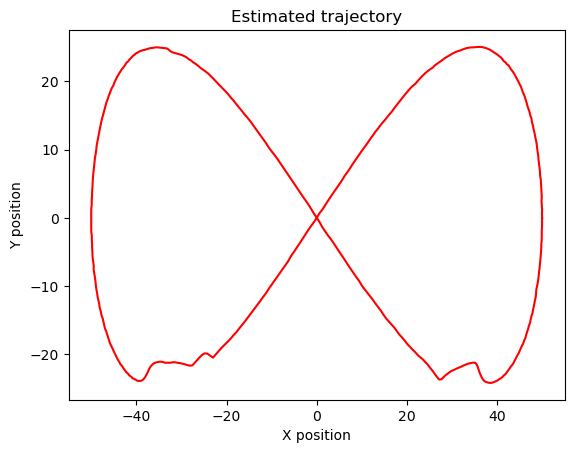

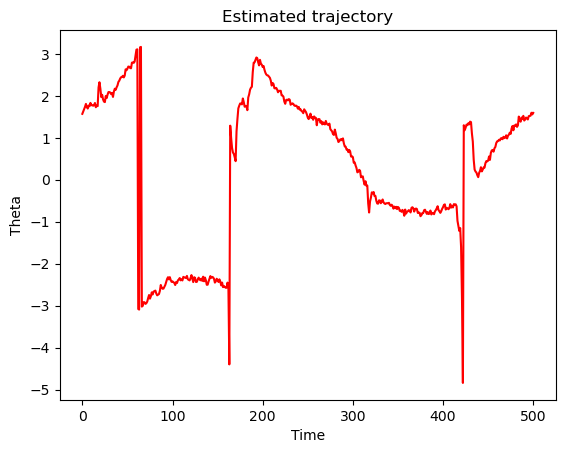

In [22]:
plt.figure()
#plt.plot(X[:,0],X[:,1],'b')
plt.plot(x_est[:,0],x_est[:,1],'r')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.title('Estimated trajectory')
plt.show()

plt.figure()
#plt.plot(t[:],X[:,2],'b')
plt.plot(t[:],x_est[:,2],'r')
plt.xlabel('Time')
plt.ylabel('Theta')
plt.title('Estimated trajectory')
plt.show()